# Multi-Class Classification on Medical MNIST
### Note
1. in multi-class, there is NO roc curve
2. cross validate on '80' split of data and get train and val error/acc (Discard the models learnt here in every step of cross validation)
3. finally, using the '20' split of data get the confusion matrix and test acc/error. This is obtained using the model trained on complete Train set

In [1]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import math
from sklearn import decomposition

## Classification Performance Metrics

In [2]:
'''
input-
y_pred, y_true shape is (n,) (NOT in one-hot representation)
multi-class such that ypred,ytrue has values in 0,1,2,..,label-1

In confusion matrix, it is assumed that there are 6 labels.

output-
precisions, recalls, F1s numpy arrays of shape (no. of labels,)
confusion matrix - numpy matrix (label,label)
'''
def classification_performance_metrics(y_pred, y_true, exp_name):
    
    y_pred = y_pred.astype('uint8')
    y_true = y_true.astype('uint8')
    
    confusion_matrix = np.zeros((6,6)) #left side - actual, top side - predicted
    for true_label in range(6):
        true_indices = y_true==true_label
        for pred_label in range(6):
            check_pred_labels = y_pred[true_indices]
            confusion_matrix[true_label][pred_label]= (check_pred_labels == pred_label).sum()
    confusion_matrix/=(confusion_matrix.sum(axis=1,keepdims=True))    #normalise it - dividing by column sum

    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    precisions, recalls, F1s = [], [], []
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

        precisions.append(precision)
        recalls.append(recall)
        F1s.append(F1)
        
    if exp_name!=None:
        #save csv files
        categories=["AbdomenCT","BreastMRI","ChestCT","CXR","Hand","HeadCT"]
        dikt = {}
        dikt['Precision']=np.round(precisions,3)
        dikt['Recall']=np.round(recalls,3)
        dikt['F1']=np.round(F1s,3)

        df = pd.DataFrame(data=dikt,index=categories)
        df.to_csv('%s_perClass.csv'%exp_name)
        df = pd.DataFrame(data=np.round(confusion_matrix,3),index=categories,columns=categories)
        df.to_csv('%s_ConfMat.csv'%exp_name)
    
    
    precisions=np.array(precisions)
    recalls=np.array(recalls)
    F1s=np.array(F1s)
    macro_F1=F1s.mean()
    
    return precisions, recalls, F1s, macro_F1, confusion_matrix

def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/y_true.shape[0]

### Data Preprocessing

In [3]:
category = {}
category[0] = "AbdomenCT"
category[1] = "BreastMRI"
category[2] = "ChestCT"
category[3] = "CXR"
category[4] = "Hand"
category[5] = "HeadCT"
path = './Medical_MNIST/'

In [4]:
train_data=np.load('train.npy').astype(np.float64) #loading as float because i have to normalise later
np.random.shuffle(train_data)
TEST_data=np.load('test.npy').astype(np.float64)
print(train_data.shape, train_data.dtype)
print(TEST_data.shape, TEST_data.dtype)

(47163, 4097) float64
(11791, 4097) float64


In [5]:
pca=decomposition.PCA(n_components=2)
pca.fit(train_data[:,:-1])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
transformed_train_data_X = pca.transform(train_data[:,:-1])
transformed_TEST_data_X = pca.transform(TEST_data[:,:-1])

train_data = np.hstack((transformed_train_data_X,train_data[:,-1:]))
TEST_data = np.hstack((transformed_TEST_data_X, TEST_data[:,-1:]))
print(train_data.shape, TEST_data.shape)

(47163, 3) (11791, 3)


In [7]:
#computing mean and stddev from whole train set (0.80*total data)
mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)

In [8]:
train_data[:,:-1]-=mean
TEST_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]/=stddev

In [9]:
Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(11791, 2) (11791, 1)


In [10]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
k = no. of neighbours
metric - 0,1,2 norm : distance/metric between two vectors | 0 means infinite norm

output-
y_pred (n,)
'''
def Predict_using_KNN(train_data, X_test, k, metric):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1:]
    y_pred_test = np.zeros((X_test.shape[0],),dtype='uint8')
    for i in range(len(X_test)):
        print('i=%u'%i,end='\r')
        x = X_test[i].reshape(1,-1)
        metrics = np.absolute(X_train-x)
        if metric==0:
            metrics = metrics.max(axis=1)
        elif metric==1:
            metrics = metrics.sum(axis=1)
        else: # metric=2
            metrics = np.sqrt(np.square(metrics).sum(axis=1))

        metrics_mapped_to_labels = np.column_stack((metrics,y_train))
        metrics_mapped_to_labels = metrics_mapped_to_labels[metrics_mapped_to_labels[:,0].argsort()]

        #now estimate the posteriors for all the classes (basically here Q_i = k_i/k is computed, k is removed)
        Q = np.zeros((6,))
        for j in range(k):
            label = int(metrics_mapped_to_labels[j,1])
            Q[label]+=1
        y_pred_test[i] = Q.argmax()
    return y_pred_test

In [13]:
#cross validate
def cross_validate(Cross_Validation_data, k, metric):
    #cross validate to get per-class precision, recall, F1, macro F1, accuracy
    precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, test_acc_CV = [],[],[],[],[]

    for i,validation_data in enumerate(Cross_Validation_data):

        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1].astype(np.uint8)
        y_pred_test = Predict_using_KNN(train, X_test, k=k, metric=metric)
        
        tupple = classification_performance_metrics(y_pred_test, y_test,None)

        test_acc_CV.append(accuracy(y_pred_test, y_test))
        precisions_CV.append(tupple[0])
        recalls_CV.append(tupple[1])
        F1s_CV.append(tupple[2])
        macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
        
#         break
    
    n_cv = len(precisions_CV)
    precisions, recalls, F1s, macro_F1, test_acc = sum(precisions_CV)/n_cv, sum(recalls_CV)/n_cv, sum(F1s_CV)/n_cv, sum(macro_F1_CV)/n_cv, sum(test_acc_CV)/n_cv
    return precisions, recalls, F1s, macro_F1, test_acc

k=1
0.969892929078766
k=5
0.9786918265663097
k=25
0.9790098590056185
k=125
0.9742393724159865
k=625
0.9671366479380897


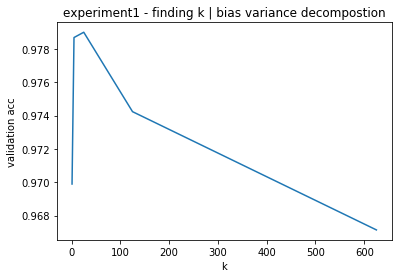

In [25]:
test_accs = []
ks=[1,5,25,125,625]
for k in ks:
    print('k=%u'%k)
    _ = cross_validate(Cross_Validation_data, k=k, metric=2)
    print(_[-1])
    test_accs.append(_[-1])
plt.title('experiment1 - finding k | bias variance decompostion')
plt.plot(ks, test_accs)
plt.xlabel('k')
plt.ylabel('validation acc')
plt.show()
np.save('val_accs_KNN.npy',test_accs)

In [26]:
val_accs_KNN=test_accs

norm=0
0.9819781617725007
norm=1
0.9817661401462949
norm=2
0.9819781617725007


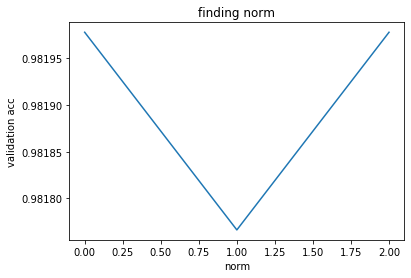

In [14]:
test_accs = []
norms=[0,1,2]
for norm in norms:
    print('norm=%u'%norm)
    _ = cross_validate(Cross_Validation_data, k=5, metric=norm)
    print(_[-1])
    test_accs.append(_[-1])
plt.title('finding norm')
plt.plot(norms, test_accs)
plt.xlabel('norm')
plt.ylabel('validation acc')
plt.savefig('findingNorm.png')
plt.show()

In [29]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
val_perf = cross_validate(Cross_Validation_data, k=5, metric=1)
print("cross validation")
print('validation acc =',val_perf[-1],"; validation macro F1 =",val_perf[-2])

cross validation
validation acc = 0.9797519346973391 ; validation macro F1 = 0.9802539790120449


In [31]:
#now finally, train on complete TRAIN set and evaluate TEST
y_pred_TEST = Predict_using_KNN(train_data, TEST_data[:,:-1], k=5, metric=2)
test_metrics=classification_performance_metrics(y_pred_TEST, TEST_data[:,-1],'KNN')
np.save('y_pred_TEST_KNN.npy',y_pred_TEST)
print("TEST accuracy, TEST macro F1", accuracy(y_pred_TEST, TEST_data[:,-1]),test_metrics[-2])

TEST accuracy, TEST macro F1 0.978882198286829 0.9790171451004502


In [13]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
h = window size => x belongs in hypercube (of vol h^d) centered at x0 if np.max(np.absolute(x-xo))<=h/2

output-
y_pred (n,)
'''
def Predict_using_Parzen(train_data, X_test, h):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1].astype(np.uint8)
    priors = np.bincount(y_train)/y_train.shape[0]
    
    y_pred_test = np.zeros((X_test.shape[0],),dtype='uint8')
    for i in range(len(X_test)):
        print('i=%u'%i,end='\r')
        x = X_test[i].reshape(1,-1)
        window_fn = np.max(np.absolute(X_train-x),axis=1) <= (h/2)
        labels_inside_window = y_train[window_fn]
        
        #now estimate the posteriors for both the classes (basically here Q_i = p_i*f_i is computed; unnormalised)
        posteriors = np.zeros((6,))
        for j in range(6):
            posteriors[j] = (labels_inside_window==j).sum() * priors[j]
        y_pred_test[i] = posteriors.argmax()
    return y_pred_test

In [18]:
#cross validate
def cross_validate(Cross_Validation_data, h):
    #cross validate to get per-class precision, recall, F1, macro F1, accuracy
    precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, test_acc_CV = [],[],[],[],[]

    for i,validation_data in enumerate(Cross_Validation_data):

        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        train = remaining_data_for_training
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1].astype(np.uint8)
        y_pred_test = Predict_using_Parzen(train, X_test, h=h)
        
        tupple = classification_performance_metrics(y_pred_test, y_test,None)

        test_acc_CV.append(accuracy(y_pred_test, y_test))
        precisions_CV.append(tupple[0])
        recalls_CV.append(tupple[1])
        F1s_CV.append(tupple[2])
        macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
        
#         break
    
    n_cv = len(precisions_CV)
    precisions, recalls, F1s, macro_F1, test_acc = sum(precisions_CV)/n_cv, sum(recalls_CV)/n_cv, sum(F1s_CV)/n_cv, sum(macro_F1_CV)/n_cv, sum(test_acc_CV)/n_cv
    return precisions, recalls, F1s, macro_F1, test_acc

h=0.001000
0.22495494540443126
h=0.005000
0.46453938301706776
h=0.010000
0.6853599067104845
h=0.050000
0.9612000424043252
h=0.100000
0.9737093183504717
h=1.000000
0.9243082794445033
h=2.000000
0.7509806000212021


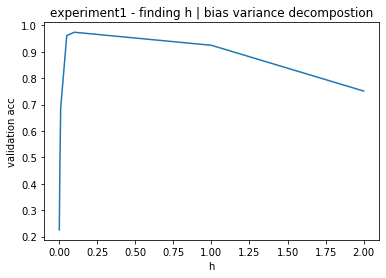

In [19]:
test_accs = []
hs=[0.001, 0.005, 0.01, 0.05, 0.1, 1,2]
for h in hs:
    print('h=%f'%h)
    _ = cross_validate(Cross_Validation_data, h=h)
    print(_[-1])
    test_accs.append(_[-1])
plt.title('experiment1 - finding h | bias variance decompostion')
plt.plot(hs, test_accs)
plt.xlabel('h')
plt.ylabel('validation acc')
np.save('val_accs_Parzen.npy',test_accs)
plt.show()

In [20]:
val_accs_Parzen = test_accs

In [21]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
val_perf = cross_validate(Cross_Validation_data,h=0.1)
print("cross validation")
print('validation acc =',val_perf[-1],"; validation macro F1 =",val_perf[-2])    

cross validation
validation acc = 0.9737093183504717 ; validation macro F1 = 0.9741498077563723


In [22]:
#now finally, train on complete TRAIN set and evaluate TEST
y_pred_TEST = Predict_using_Parzen(train_data, TEST_data[:,:-1], h=0.1)
test_metrics=classification_performance_metrics(y_pred_TEST, TEST_data[:,-1],'Parzen')
np.save('y_pred_TEST_Parzen.npy',y_pred_TEST)
print(accuracy(y_pred_TEST, TEST_data[:,-1]),test_metrics[-2])

0.976083453481469 0.9761603521307746


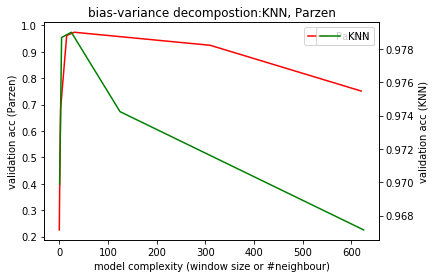

In [46]:
fig,ax = plt.subplots()
plt.title('bias-variance decompostion:KNN, Parzen')
x=[310*h for h in hs]
ax.plot(x, val_accs_Parzen,label='Parzen',c='r')
ax.set_xlabel("model complexity (window size or #neighbour)")
ax.set_ylabel('validation acc (Parzen)')
plt.legend()
ax2=ax.twinx()
x=ks
ax2.plot(x, val_accs_KNN,label='KNN',c='g')
ax2.set_ylabel('validation acc (KNN)')
plt.savefig('BiasVariance_KNNParzen.png')
plt.legend()
plt.show()